# Customer Segmentation ML Pipeline

**Author:** Marketing Insight Pipeline Project  
**Version:** 1.0  
**Last Updated:** December 2024

This notebook implements an end-to-end customer segmentation pipeline using RFM (Recency, Frequency, Monetary) features and K-means clustering on Snowflake sales data. The output is a set of customer segments for targeted marketing.



In [27]:
# Load environment variables
import os
from dotenv import load_dotenv

load_dotenv('../.env')

SNOWFLAKE_CONFIG = {
    'account':   os.getenv('SNOWFLAKE_ACCOUNT'),
    'user':      os.getenv('DBT_USER'),
    'password':  os.getenv('DBT_PASSWORD'),
    'warehouse': os.getenv('SNOWFLAKE_WAREHOUSE'),
    'database':  os.getenv('SNOWFLAKE_DATABASE'),
    'schema':    os.getenv('DBT_SCHEMA', 'DBT_SKAMRA_ANALYTICS'),
}


print(SNOWFLAKE_CONFIG)

{'account': 'BRVIXQZ-AQ58231', 'user': 'dbt_marketing', 'password': 'dbtPassword123', 'warehouse': 'MARKETING_WH', 'database': 'MARKETING_INSIGHTS_DB', 'schema': 'DBT_SKAMRA_ANALYTICS'}


In [28]:
# Core imports
import pandas as pd
import numpy as np
import joblib
import json
from datetime import datetime

# Snowflake connector
import snowflake.connector


In [29]:
# 2. Connect to Snowflake and extract sales data
ctx = snowflake.connector.connect(
    account   = SNOWFLAKE_CONFIG['account'],
    user      = SNOWFLAKE_CONFIG['user'],
    password  = SNOWFLAKE_CONFIG['password'],
    warehouse = SNOWFLAKE_CONFIG['warehouse'],
    database  = SNOWFLAKE_CONFIG['database'],
    schema    = SNOWFLAKE_CONFIG['schema'],
)
cs = ctx.cursor()
query = """
SELECT
  CUSTOMER_ID,
  TRANSACTION_DATE,
  NET_SALES_AMOUNT AS sales_amount
FROM fct_sales
WHERE TRANSACTION_DATE IS NOT NULL
"""
df = pd.read_sql(query, ctx)
df.columns = df.columns.str.lower()

cs.close()
ctx.close()
print(f"Extracted {len(df)} rows from Snowflake.")
df.head()


/var/folders/cm/qvwnybj51ll82slvk54rryrw0000gn/T/ipykernel_71402/1638337619.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, ctx)


Extracted 52924 rows from Snowflake.


,customer_id,transaction_date,sales_amount
0,17850,2019-01-01,122.968
1,17850,2019-01-01,122.968
2,17850,2019-01-01,1.640
3,17850,2019-01-01,87.650
4,17850,2019-01-01,13.200


## 3. Exploratory Data Analysis


In [30]:
# Convert dates and inspect
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
print(df.describe())
print("\nUnique customers:", df['customer_id'].nunique())


       customer_id               transaction_date  sales_amount
count  52924.00000                          52924  52924.000000
mean   15346.70981  2019-07-05 19:16:09.450532864     82.388213
min    12346.00000            2019-01-01 00:00:00      0.320000
25%    13869.00000            2019-04-12 00:00:00     10.872000
50%    15311.00000            2019-07-13 00:00:00     28.000000
75%    16996.25000            2019-09-27 00:00:00    119.000000
max    18283.00000            2019-12-31 00:00:00   8409.912000
std     1766.55602                            NaN    152.871083

Unique customers: 1468


<Axes: >

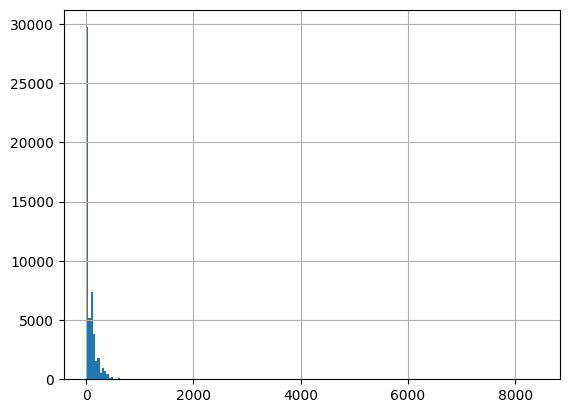

In [31]:
# Quick histogram of sales amounts
df['sales_amount'].hist(bins=200)


## 4. Feature Engineering (RFM)
1. **Recency**: days since last purchase  
2. **Frequency**: number of transactions  
3. **Monetary**: total spend  
4. **Additional**: average order value, discount sensitivity (if available)


In [32]:
# Reference date at run time
snapshot_date = df['transaction_date'].max() + pd.Timedelta(days=1)

# Compute RFM table
rfm = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days,
    'sales_amount': ['count', 'sum', 'mean']
}).reset_index()

rfm.columns = ['customer_id', 'recency_days', 'frequency', 'monetary', 'avg_order_value']
print(rfm.head())


   customer_id  recency_days  frequency   monetary  avg_order_value
0        12346           108          2     24.792        12.396000
1        12347            60         60  13219.940       220.332333
2        12348            74         23   1301.030        56.566522
3        12350            18         17   1258.592        74.034824
4        12356           108         36   1304.638        36.239944


## 5. Data Scaling & Normalization
K-means is distance-based, so we'll standardize our features.


In [33]:
from sklearn.preprocessing import StandardScaler

features = ['recency_days', 'frequency', 'monetary', 'avg_order_value']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])


## 6. Choosing K: Elbow Method & Silhouette


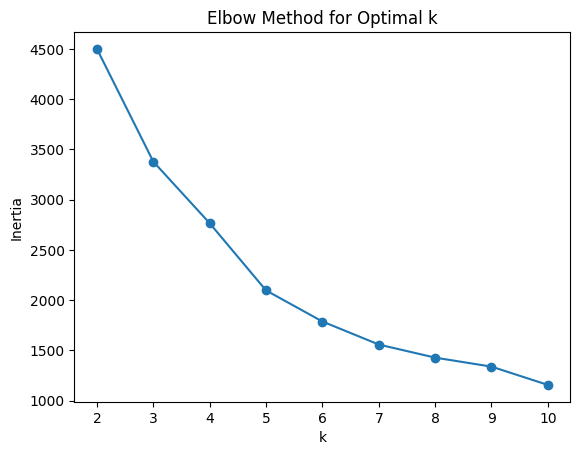

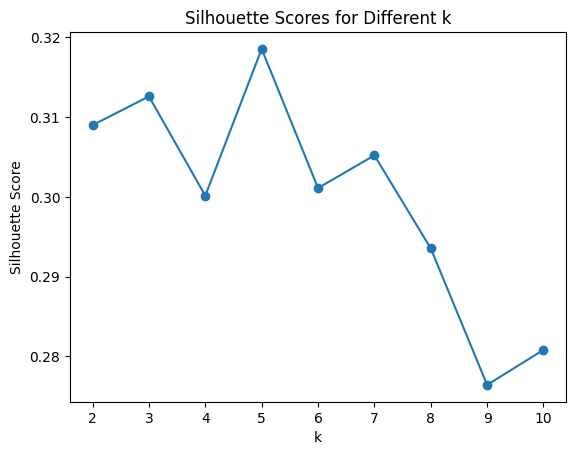

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

# Plot Elbow
import matplotlib.pyplot as plt

plt.figure()
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.show()

# Plot Silhouette
plt.figure()
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('k'); plt.ylabel('Silhouette Score')
plt.show()


### Selecting the best k
*From these plots, choose the best k (e.g. k=5).*

Both the Elbow and Silhouette plots point to k = 5 as the sweet-spot:

Elbow curve

Inertia drops sharply from k=2→3→4→5, then the rate of decline flattens out after k=5.

That “knee” around 4–5 means you get most of your within-cluster compactness by five clusters.

Silhouette scores

Peaks at k=5 (≈ 0.318), indicating the best average separation between clusters.

All other k have lower silhouette values, so cluster cohesion + separation is optimal at five.

Business interpretability

Five segments map neatly onto classic RFM personas (e.g. High-Value, Loyal, At-Risk, Price-Sensitive, New), making rollout and targeting straightforward.

In [35]:
# 7. Train final K-means
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42)
rfm['segment_id'] = kmeans.fit_predict(rfm_scaled)


In [36]:
# 8. Evaluate clusters
print("Silhouette score:", silhouette_score(rfm_scaled, rfm['segment_id']))


Silhouette score: 0.31855749577506326


## 9. Profile & Name Segments
Compute average RFM per cluster and assign business-centric names.


In [37]:
profile = rfm.groupby('segment_id')[features].mean().round(2)
profile['count'] = rfm.groupby('segment_id').size()
profile = profile.sort_values('monetary', ascending=False)
profile


,recency_days,frequency,monetary,avg_order_value,count
segment_id,,,,,
3,61.78,465.56,44348.32,95.89,9
4,78.46,111.12,9200.44,85.95,168
0,73.26,19.74,3021.31,164.66,207
1,266.59,22.07,1662.15,71.27,474
2,95.12,25.44,1643.01,59.44,610


## Naming the segments based on this logic

| segment\_id | Recency (days) | Frequency | Monetary | Avg. Order | Count | Proposed Name           | Rationale                                                        |
| ----------: | -------------: | --------: | -------: | ---------: | ----: | ----------------------- | ---------------------------------------------------------------- |
|           3 |           61.8 |     465.6 | 44,348.3 |       95.9 |     9 | **Champions (VIPs)**    | By far the most frequent purchasers and highest spenders.        |
|           4 |           78.5 |     111.1 |  9,200.4 |       85.9 |   168 | **Loyal Customers**     | Very active, high spend—reliably engaged but a bit less than #3. |
|           0 |           73.3 |      19.7 |  3,021.3 |      164.7 |   207 | **Big Spenders**        | Infrequent visits but very high average order value.             |
|           1 |          266.6 |      22.1 |  1,662.2 |       71.3 |   474 | **At-Risk (Lapsing)**   | Long time since last buy with low overall value—watch for churn. |
|           2 |           95.1 |      25.4 |  1,643.0 |       59.4 |   610 | **Occasional Shoppers** | Moderate frequency & spend; less predictable purchase cadence.   |


In [38]:
# 10. Profile & Name Segments (revised)
mapping = {
    3: 'Champions (VIPs)',
    4: 'Loyal Customers',
    0: 'Big Spenders',
    2: 'Occasional Shoppers',
    1: 'At-Risk (Lapsing)'
}
rfm['segment_name'] = rfm['segment_id'].map(mapping)


## 10. Save Artifacts & Results


In [39]:
import os

os.makedirs('../models', exist_ok=True)

# Save models
joblib.dump(kmeans, '../models/customer_segmentation_model.pkl')
joblib.dump(scaler, '../models/feature_scaler.pkl')

# Save cluster assignments
rfm[['customer_id','segment_id','segment_name']].to_csv(
    '../models/customer_segments.csv', index=False
)

# Save evaluation metrics
metrics = {
    'silhouette_score': float(silhouette_score(rfm_scaled, rfm['segment_id'])),
    'inertia': kmeans.inertia_,
    'segment_counts': rfm['segment_id'].value_counts().to_dict()
}
with open('../models/evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("Artifacts saved under `models/`.")


Artifacts saved under `models/`.
